In [590]:
import pandas as pd
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import textwrap
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)

from sklearn import svm
from sklearn.metrics import hinge_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn import linear_model
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [615]:
#Imputed Data 2
do = pd.read_csv("clean_2017-2019.csv")
di2 = pd.read_csv("imputed_data_r2.csv")

#Pre-process primarily tech company responses
t = do['primarily_tech']
t = t.fillna(False)
t = t.astype(float)
di2['primarily_tech'] = t

s = do['sought_treatment']
s = s.astype(float)
di2['sought_treatment'] = s

di2.head()

,Unnamed: 0,country_live,country_work,state_live,state_work,race,gender,year,interview_why,family_history,...,share_with_f&f,num_employees,ever_diagnosed,identified,identifited_neg_consequences,medical_coverage,primarily_tech,primary_role_tech,self-employed,sought_treatment
0,0,United Kingdom,United Kingdom,NaN,NaN,NaN,F,2017.0,I'd be worried they wouldn't hire me,No,...,5,100-500,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1,1,United Kingdom,United Kingdom,NaN,NaN,NaN,M,2017.0,mental health issues are stigmatised and misun...,No,...,4,100-500,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,2,United States of America,United States of America,Missouri,Missouri,White,M,2017.0,stigma,Yes,...,5,6-25,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,3,United States of America,United States of America,Washington,Washington,White,M,2017.0,Might hurt my chances,I don't know,...,10,More than 1000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,4,United States of America,United States of America,Illinois,Illinois,More than one,F,2017.0,Don't think it's connected to the job. You do ...,Yes,...,10,100-500,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [617]:
di2['country_work'].unique()

array(['United Kingdom', 'United States of America', 'Switzerland',
       'India', 'Russia', 'Bangladesh', 'Germany', 'Canada', 'Israel',
       'Iceland', 'Japan', 'Indonesia', 'Portugal', 'Romania', 'Finland',
       'Pakistan', 'Australia', 'South Africa', 'Sweden', 'Serbia',
       'Spain', 'Jordan', 'Hungary', 'Croatia', 'Bulgaria', 'New Zealand',
       'Italy', 'Argentina', 'Eritrea', 'Greece', 'Austria',
       'Netherlands', 'France', 'Mexico', 'Swaziland', 'Brazil',
       'Ukraine', 'Ireland', 'Poland', 'Belgium', 'Singapore', 'Slovakia',
       'Luxembourg', 'Turkey', 'Czech Republic', 'Latvia', nan, 'Norway',
       'Colombia', 'Estonia', 'Mauritius', 'Saudi Arabia', 'Nigeria',
       'Kenya', 'Uruguay', 'Ethiopia', 'Macedonia', 'Hong Kong',
       'Georgia', 'Other', 'Ghana', 'Botswana', 'Algeria', 'Afghanistan'],
      dtype=object)

# PART A:
## Apply Feature Transformations 

country_work = one hot encoding (1.0 = United States, 0.0 = Other)  
family history = boolean (1.0 = Yes, 0.0 = No/IDK)  
past_disorder = ordinal one hot encoding (1.0 =Yes, 0.0 otherwise)  

mention interview = ordinal(1 = No, 2 = Maybe, 3 = Yes)  
know_resources = ordinal(1 = No, I don't know any, 2 = I know some, 3 = 'Yes I know several')  
emp_mh_resources = ordinal(1 = No, 2 = I don't know, 3 = Yes)  
mh_benefits = ordinal(1 = No, 2 = Not eligible for coverage / NA, 3 = I don't know, 4 = Yes)  
mh_with_coworkers = ordinal(1 = No, 2 = Maybe, 3 = Yes)  
mh_with_supervisor = ordinal(1 = No, 2 = Maybe, 3 = Yes)  


ph_or_mh_discuss = ordinal(0 = Physical health, 1 =  Mental health, 2 = Same level of comfort for each)  
reveal_to_clients = ordinal(0 = 'No, because it would impact me negatively',1 = No, because it doesn't  matter,2 = sometimes, if it comes up, 3 = Yes always, 4 = N/A)  
    
    
    
    

share_with_f&f = ordinal(1 = Response between 1 and 4 (unlikely), 2 = Response between 5 and 7 (likely),32= Response between 8 and 10 (likely))    
numemployees = ordinal(0 = small '1-5' or '6-25',1 = medium '100-500' or '500-1000', large = 'More than 1000')  


identifited_neg_consequences: already boolean (1.0 = Yes, 0 = No)  
medical_coverage: already boolean (1.0 = Yes, 0 = No)   
primarily_tech: already boolean (1.0 = Yes, 0 = No)   
primary_role_tech: already boolean (1.0 = Yes, 0 = No)    


*All values are normalized using the functions below

In [634]:
#Encode data using floats (Includes some boolean 0/1 encodings, 
#as well as one hot encodings, and many hot encodings, normalized b/w 0.0 and 1.0

def convertArrayTo3Scale(array,r1,r2,r3):
    a1 = (array == r1)
    a2 = (array == r2)*0.5
    a3 = (array == r3)*1

    return a1+a2+a3

a_mention_interview = convertArrayTo3Scale(di2['mention_interview'].to_numpy(), 'No','Maybe','Yes')
a_know_resources = convertArrayTo3Scale(di2['know_resources'].to_numpy(), "No, I don't know any",'I know some','Yes, I know several')
a_emp_mh_resources = convertArrayTo3Scale(di2['emp_mh_resources'].to_numpy(),"No","I don't know","Yes")

def convertArrayTo4Scale(array,r1,r2,r3,r4):
    a1 = (array == r1)
    a2 = (array == r2)*(1.0/3.0)
    a3 = (array == r3)*(2.0/3.0)
    a4 = (array == r4)*1
    
    return a1+a2+a3+a4

def convert1To10Ratings(array):
    a1 = (array <= 5)
    a2 = ((array == 5)|(array==6)|(array==7))*0.5
    a3 = ((array == 8)|(array==9)|(array==10))*1
    
    return a1+a2+a3

def convertNumEmployees(array):
    a1 = (array == '1-5')|(array == '6-25')
    a2 = (array == '26-100')*(1.0/3.0)
    a3 = ((array == '100-500')|(array == '500-1000'))*(2.0/3.0)
    a4 = (array == 'More than 1000')*1
    
    return a1+a2+a3+a4

a_country_work = di2['country_work'] == 'United States of America'
a_mention_interview = convertArrayTo3Scale(di2['mention_interview'].to_numpy(), 'No','Maybe','Yes')
a_know_resources = convertArrayTo3Scale(di2['know_resources'].to_numpy(), "No, I don't know any",'I know some','Yes, I know several')
a_emp_mh_resources = convertArrayTo3Scale(di2['emp_mh_resources'].to_numpy(),"No","I don't know","Yes")
a_mh_benefits = convertArrayTo4Scale(di2['mh_benefits'].to_numpy(),"No","Not eligible for coverage / NA","I don't know","Yes")
a_mh_with_coworkers = convertArrayTo3Scale(di2['mh_with_coworkers'].to_numpy(),"No","Maybe","Yes")
a_mh_with_supervisor = convertArrayTo3Scale(di2['mh_with_supervisor'].to_numpy(),"No","Maybe","Yes")

a_ph_or_mh_discuss = convertArrayTo3Scale(di2['ph_or_mh_discuss'].to_numpy(),"Physical health","Same level of comfort for each","Mental health")
a_reveal_to_clients =  convertArrayTo4Scale(di2['reveal_to_clients'].to_numpy(),"No, because it would impact me negatively","No, because it doesn't matter","Sometimes, if it comes up",'Yes, always')

a_share_with_ff  = convert1To10Ratings(di2['share_with_f&f']) 
a_num_employees =convertNumEmployees(di2['num_employees'])


#No feature transformation needed
a_identifited_neg_consequences = di2['identifited_neg_consequences']
a_medical_coverage = di2['medical_coverage']
a_primarily_tech = di2['primarily_tech']
a_primary_role_tech = di2['primary_role_tech']


# Construct X

In [646]:
X = [a_country_work,a_mention_interview, a_know_resources, a_emp_mh_resources, a_mh_benefits,\
     a_mh_with_coworkers ,a_mh_with_supervisor,a_ph_or_mh_discuss, a_reveal_to_clients,\
     a_share_with_ff,a_num_employees,a_identifited_neg_consequences,a_medical_coverage,\
     a_primarily_tech,a_primary_role_tech]
X = np.transpose(X)

# Construct Y

In [656]:
#What I am trying to predict
y = do['sought_treatment']
y.to_numpy().astype(float)

array([1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 1.

# Split Into Train and Test Sets

In [657]:
TRAIN_PROPORTION = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_PROPORTION, random_state=20)

# Try Squared Hinge Loss, (With l2 regularization default)

# Try Hinge Loss, (With l2 regularization default)

In [658]:
est = svm.LinearSVC(loss = 'hinge',random_state=0,max_iter=1000000, C=1)
est.fit(X_train, y_train)

pred_decision = est.decision_function(X_train)
hinge_loss(y_train, pred_decision)

predicted_y_test = est.predict(X_test)
print("Accuracy of model on train set = ", round(est.score(X_train,y_train),3))
print("Accuracy of model on test set = ",round(est.score(X_test, y_test),3))

#accuracy_score(y_test, predicted_y)

print("F1 score for test set = ",round(f1_score(y_test, predicted_y_test),3))

est.score(X_train,y_train)



Accuracy of model on train set =  0.681
Accuracy of model on test set =  0.711
F1 score for test set =  0.794


0.6811475409836065

# PART B
## Validating Model: k-cross fold validation:
80% training (976 respondants, 20% test (244 respondants) from X_train


highest accuracy score =  0.692
avg accuracy score =  0.66
avg F1 score =  0.736


Text(0.5, 1.0, 'Model Average Coefficients For Cross Validation Models, Hinge Loss')

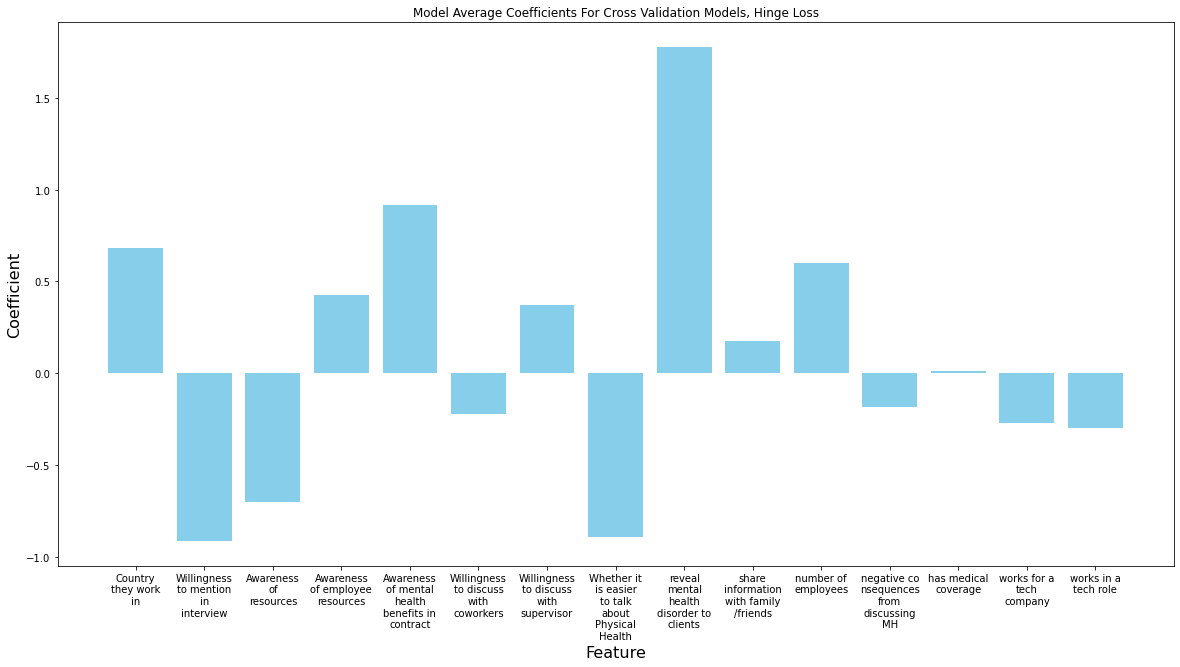

In [659]:
Coefficients = []
Intercepts = []
Test_Scores = []
F1_Scores = []

#starting index of test set 
start_test = np.arange(0,1220,244)
for i in start_test:
    #CASE 1: i+305 < 1220:
    if i+305 <= 1220:
        X_testk = X_train[i:i+305]
        y_testk = y_train[i:i+305]
        X_traink = np.concatenate((X_train[:i],X_train[(i+305):]))
        y_traink = np.concatenate((y_train[:i],y_train[(i+305):]))

    else:  #CASE 2: i+305 > 1220:
        #wrap the difference around
        X_testk = np.concatenate((X_train[i:],X_train[:305-(1220-i)]))
        y_testk = np.concatenate((y_train[i:],y_train[:305-(1220-i)]))
        X_traink = (X_train[305-(1220-i):i])
        y_traink = (y_train[305-(1220-i):i])
        
        
    #Fit Model
    est = svm.LinearSVC(loss = 'hinge',random_state=0,max_iter=100000)
    mod_fit = est.fit(X_traink, y_traink)
    Coefficients.append((est.coef_[0]))
    Intercepts.append(est.intercept_[0])
    
    #Measure performance
    Test_Scores.append(est.score(X_testk,y_testk))
    predicted_y_testk = est.predict(X_testk)
    F1_Scores.append(f1_score(y_testk, predicted_y_testk))
    
#Compute Intercept and Coefficient Averages
Avg_Coeff = [sum(vals)/len(Coefficients) for vals in zip(*Coefficients)]
Avg_Intercepts = np.mean(Intercepts)

#General performance 
highest_Score = max(Test_Scores)
avg_Score = np.mean(Test_Scores)
avg_F1 = np.mean(F1_Scores)

print("highest accuracy score = ", round(highest_Score,3))
print("avg accuracy score = ", round(avg_Score,3))
print("avg F1 score = ", round(avg_F1,3))


labels = ['Country they work in','Willingness to mention in interview', 'Awareness of resources', 'Awareness of employee resources', 'Awareness of mental health benefits in contract',\
     'Willingness to discuss with coworkers' ,'Willingness to discuss with supervisor','Whether it is easier to talk about Physical Health', 'reveal mental health disorder to clients',\
     'share information with family/friends','number of employees','negative consequences from discussing MH','has medical coverage',\
     'works for a tech company','works in a tech role']
plt.figure(figsize=(20, 10))
plt.bar([textwrap.fill(label, 11) for label in labels],Avg_Coeff,width = 0.8, color = 'skyblue')
plt.xticks(rotation=0)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('Coefficient', fontsize = 16)
plt.title('Model Average Coefficients For Cross Validation Models, Hinge Loss')
